# Machine Learning 2 - Semester Project 
# Garbage Classification

<div class="alert alert-block alert-info">
<b>Tip:</b> Revised Order:

1. **Data Collection:**
   - Collect a dataset of images representing different types of garbage items (plastic, paper, glass, etc.).
   - Found multiple data sets on kaggle
    
2. **Image Classification:**
   - Use convolutional neural networks (CNNs) to build an image classification model.
   - Train the model to recognize and classify each type of garbage item.
   - Evaluate the model's performance using appropriate metrics.

3. **Pre-trained Models Comparison:**
   - Choose popular pre-trained models for image classification (e.g., ResNet, VGG, MobileNet).
   - Fine-tune these models on your garbage classification dataset.
   - Evaluate the performance of the fine-tuned models.
   - Compare the performance metrics with your custom-trained model.

4. **Clustering and Dimension Reduction:**
   - Apply clustering algorithms (e.g., K-Means) to group similar garbage items together.
        - (Hope to find clusters like: recycleable/ bio/ others
   - Use dimension reduction techniques (e.g., PCA) to visualize and analyze the features of the garbage items.

5. **Integrating Recommendations:**
   - Implement a recommendation system that suggests the appropriate recycling bin for a given item.
        - maybe simple tree?? 
   - Use knowledge from the clustering and dimension reduction to enhance recommendation accuracy.


</div>


### Import Libraries

In [50]:
# Standard Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Images 
import os
import glob
from PIL import Image


# Libraries for Evaluations and Train/Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#Model Visualization
from ann_visualizer.visualize import ann_viz

#Others
from tqdm import tqdm  # Optional: tqdm for progress bar
from concurrent.futures import ThreadPoolExecutor

In [4]:
def count_images_in_folder(folder_path, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp']):
    # Ensure the folder path is valid
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return None

    # Use glob to get a list of files matching the specified extensions
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, f'*.{ext}')))

    # Count the number of images
    num_images = len(image_files)

    return num_images

folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/battery'
num_images = count_images_in_folder(folder_path)

if num_images is not None:
    print(f'The folder "{folder_path}" contains {num_images} images.')


The folder "/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/battery" contains 945 images.


In [10]:
def count_images_in_subfolders(root_folder, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp']):
    # Ensure the root folder path is valid
    if not os.path.exists(root_folder):
        print(f"Error: The folder '{root_folder}' does not exist.")
        return None
    # Initialize an empty list to store results
    data = []

    # Iterate through subfolders
    for subfolder_name in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder_name)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Use glob to count images in the subfolder
            image_files = []
            for ext in image_extensions:
                image_files.extend(glob.glob(os.path.join(subfolder_path, f'*.{ext}')))

            # Count the number of images
            num_images = len(image_files)

            # Append the results to the list
            data.append({'Classes': subfolder_name, 'Number_Images': num_images})

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)

    return df

In [11]:
# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'
image_overview = count_images_in_subfolders(root_folder_path)

image_overview

,Classes,Number_Images
0,paper,1050
1,green-glass,629
2,clothes,5325
3,metal,769
4,cardboard,891
5,trash,697
6,biological,985
7,white-glass,775
8,battery,945
9,brown-glass,607


In [21]:
image_overview['Number_Images'].sum()

15515

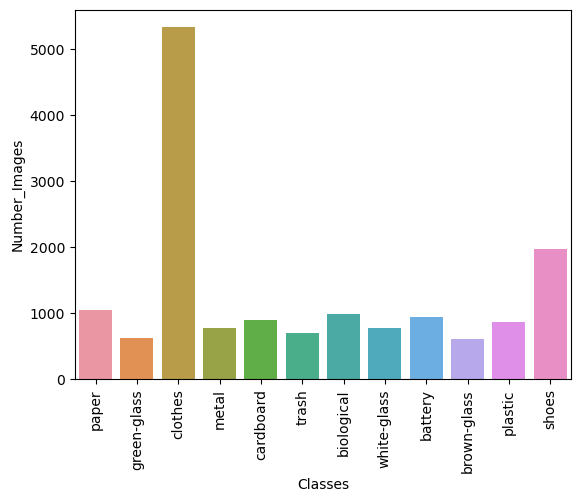

In [16]:
sns.barplot(image_overview, x="Classes", y="Number_Images")
plt.xticks(rotation=90)
plt.show()

## Different Models for Importing the Images

### Storing in a df 
- very time consuming

In [26]:
def load_images_into_dataframe(root_folder, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp'], batch_size=100):
    # Ensure the root folder path is valid
    if not os.path.exists(root_folder):
        print(f"Error: The folder '{root_folder}' does not exist.")
        return None

    data = {'Image': [], 'Label': []}

    # Function to load images in parallel
    def process_images(args):
        image_file, label = args
        try:
            # Load image using PIL
            img = Image.open(image_file)

            # Convert image to NumPy array
            img_array = np.array(img)

            # Append data to the dictionary
            data['Image'].append(img_array)
            data['Label'].append(label)
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")

    # Iterate through subfolders
    for label in tqdm(os.listdir(root_folder), desc="Processing Subfolders", unit="subfolder"):
        label_path = os.path.join(root_folder, label)

        # Check if it's a directory
        if os.path.isdir(label_path):
            # Use ThreadPoolExecutor for parallel processing
            with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
                image_files = []
                for ext in image_extensions:
                    image_files.extend(glob.glob(os.path.join(label_path, f'*.{ext}')))

                # Process images in batches
                label_image_pairs = [(image_file, label) for image_file in image_files]
                for i in tqdm(range(0, len(label_image_pairs), batch_size), desc="Processing Images", unit="batch"):
                    batch_files = label_image_pairs[i:i + batch_size]
                    executor.map(process_images, batch_files)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'
image_df = load_images_into_dataframe(root_folder_path)
image_df.head()


Processing Subfolders: 100%|█████████████| 13/13 [09:38<00:00, 44.54s/subfolder]


                                               Image  Label
0  [[[202, 202, 202], [202, 202, 202], [202, 202,...  paper
1  [[[48, 65, 75], [9, 26, 36], [15, 32, 42], [12...  paper
2  [[[197, 189, 178], [197, 189, 178], [198, 190,...  paper
3  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...  paper
4  [[[255, 254, 252], [255, 255, 253], [255, 255,...  paper


In [41]:
image_df.info

<bound method DataFrame.info of                                                    Image  Label
0      [[[202, 202, 202], [202, 202, 202], [202, 202,...  paper
1      [[[48, 65, 75], [9, 26, 36], [15, 32, 42], [12...  paper
2      [[[197, 189, 178], [197, 189, 178], [198, 190,...  paper
3      [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...  paper
4      [[[255, 254, 252], [255, 255, 253], [255, 255,...  paper
...                                                  ...    ...
15510  [[[98, 100, 63], [88, 90, 53], [116, 118, 81],...  shoes
15511  [[[183, 209, 226], [183, 209, 226], [183, 209,...  shoes
15512  [[[255, 255, 255], [255, 255, 255], [255, 255,...  shoes
15513  [[[81, 55, 20], [80, 54, 19], [78, 52, 17], [7...  shoes
15514  [[[106, 59, 43], [106, 57, 42], [105, 53, 39],...  shoes

[15515 rows x 2 columns]>

In [42]:
image_df.head()

,Image,Label
0,"[[[202, 202, 202], [202, 202, 202], [202, 202,...",paper
1,"[[[48, 65, 75], [9, 26, 36], [15, 32, 42], [12...",paper
2,"[[[197, 189, 178], [197, 189, 178], [198, 190,...",paper
3,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",paper
4,"[[[255, 254, 252], [255, 255, 253], [255, 255,...",paper


### Use ImageData Generator 

In [43]:
# Define the root folder where your subfolders (class folders) are located
root_folder_path = '/path/to/your/root/folder'
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Define the ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values to be between 0 and 1
    shear_range=0.2,      # Shear transformation
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True, # Random horizontal flip
    validation_split=0.2  # Split data into training and validation sets
)

# Define the target image size
target_size = (256,256)  # Adjust according to your model's input size

# Create the training data generator
train_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,         # Adjust based on your system's memory
    class_mode='categorical',  # Assumes a classification task
    subset='training'      # Specify 'training' for training data
)

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'    # Specify 'validation' for validation data
)


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


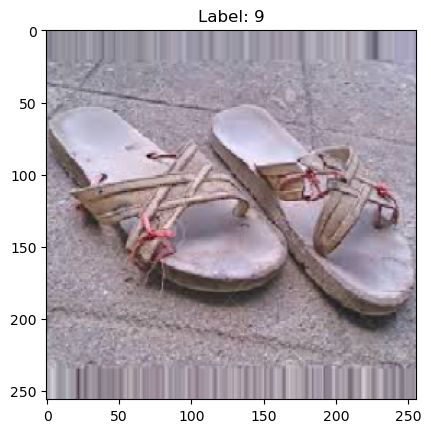

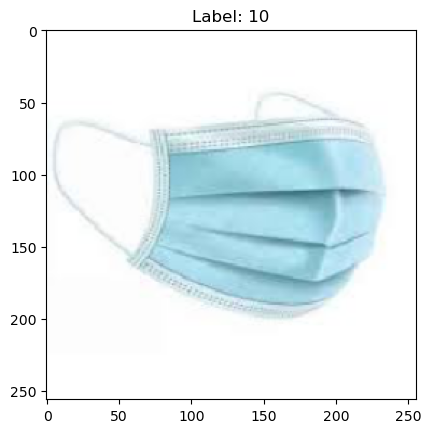

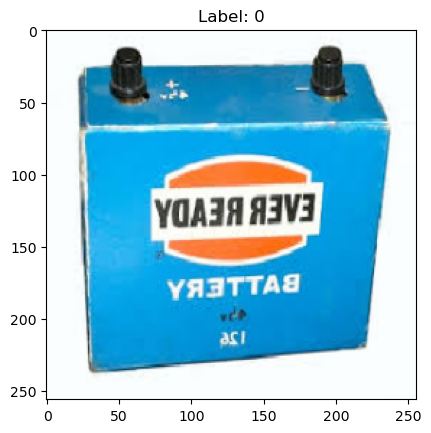

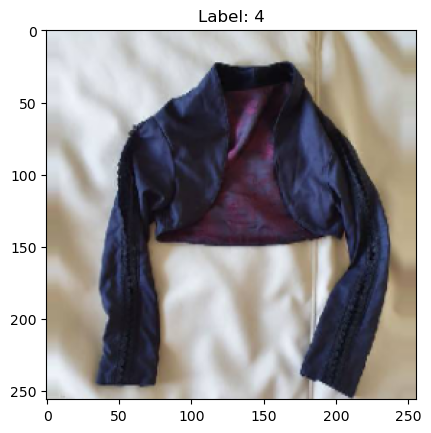

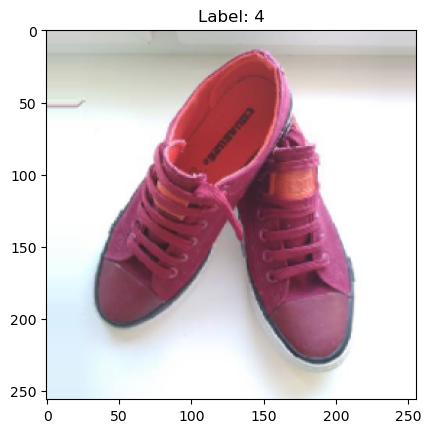

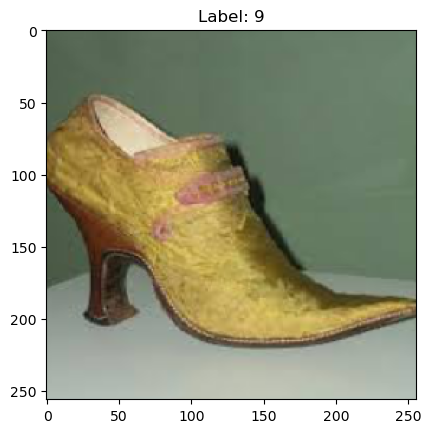

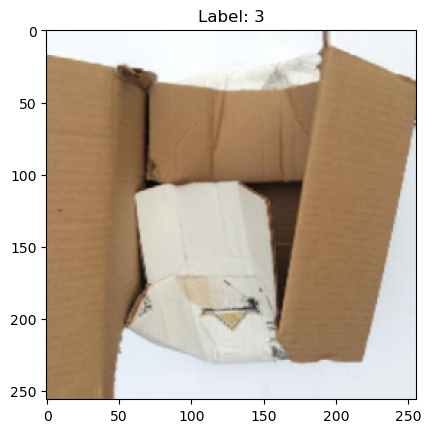

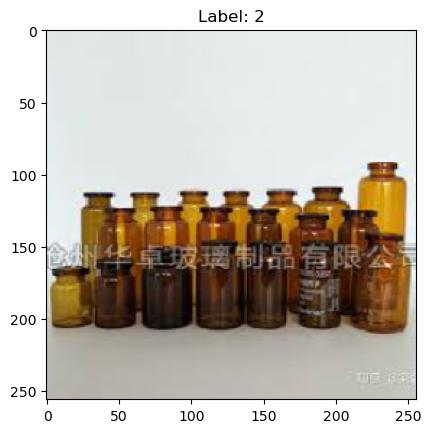

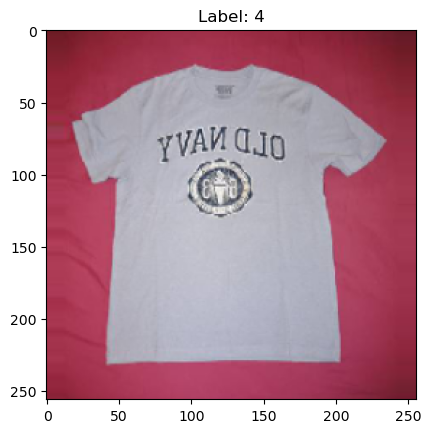

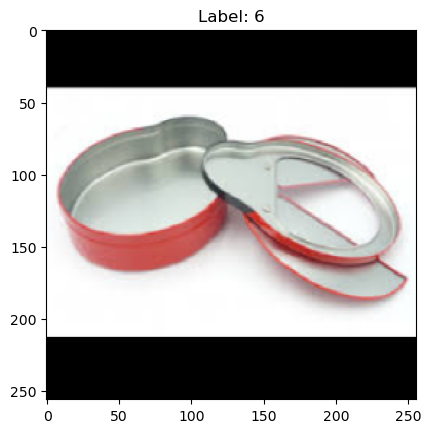

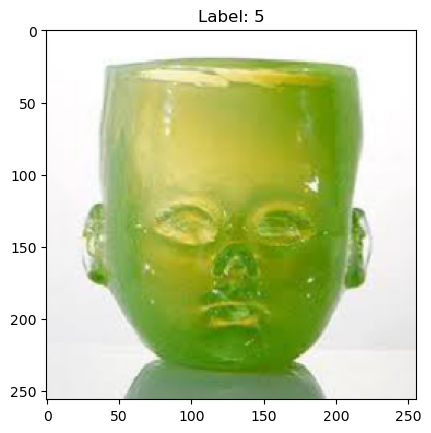

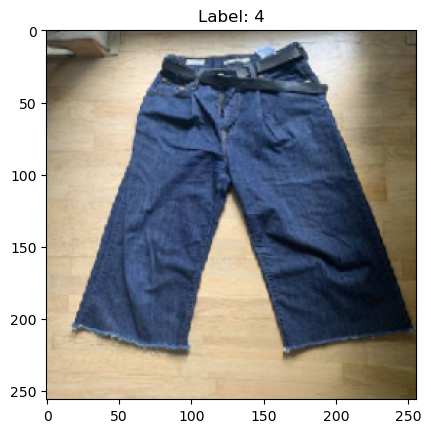

In [46]:
import matplotlib.pyplot as plt

# Get a batch from the training generator
batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 12
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label_index}")
    plt.show()

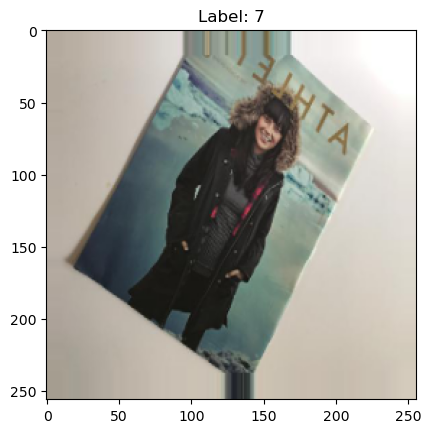

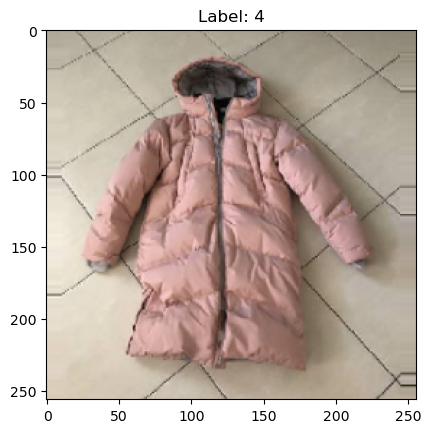

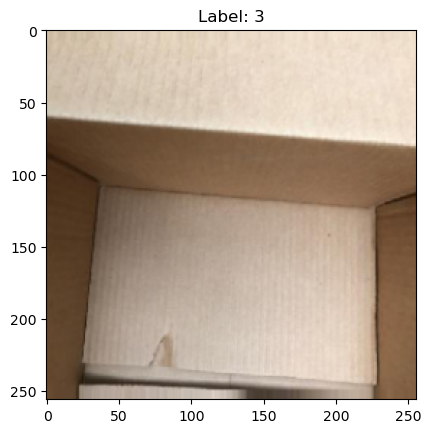

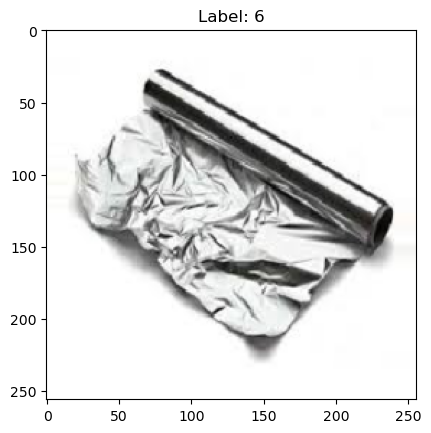

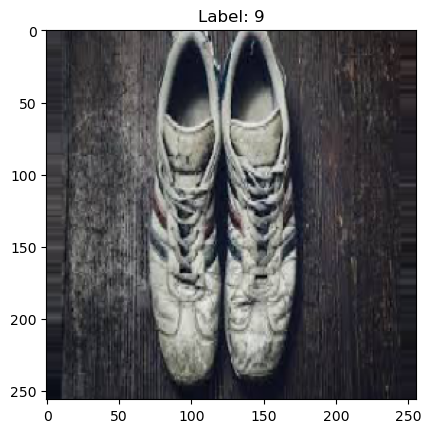

In [47]:
# Get a batch from the training generator
batch_images, batch_labels = next(validation_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 5
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label_index}")
    plt.show()

In [48]:
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


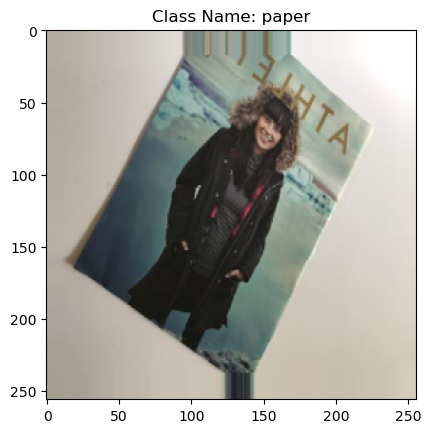

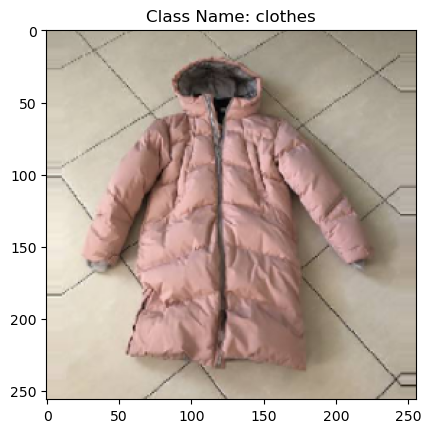

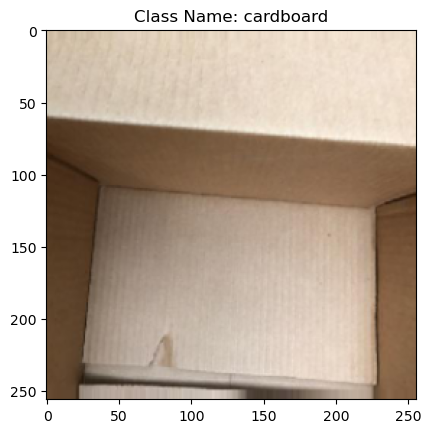

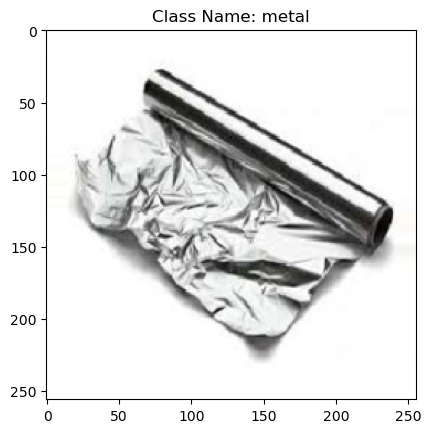

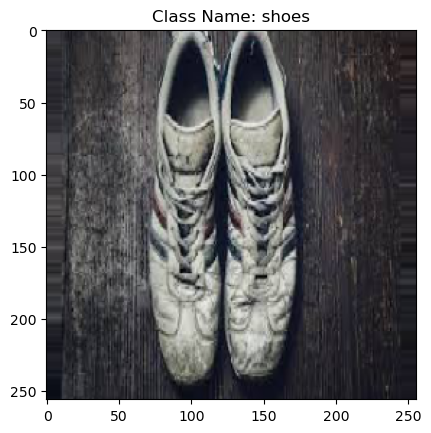

In [49]:
# Visualize the first few images in the batch with class names
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    class_name = class_names[label_index]
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Class Name: {class_name}")
    plt.show()


## Implementing CNN - own build

In [53]:
# Define the CNN model
num_classes = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256,256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust 'num_classes' based on your task
])

# Compile the model
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model with the legacy Adam optimizer
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Display the model summary
model.summary()

    # Define a callback to save the best model during training
#checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
    # Define a callback to save the best model during training in the native Keras format
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 128)      

/Users/linuszarse/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


388/388 [==============================] - 307s 791ms/step - loss: 0.9985 - accuracy: 0.6703 - val_loss: 1.1334 - val_accuracy: 0.6168
Epoch 3/10
388/388 [==============================] - 298s 767ms/step - loss: 0.8471 - accuracy: 0.7204 - val_loss: 1.0068 - val_accuracy: 0.6752
Epoch 4/10
388/388 [==============================] - 361s 928ms/step - loss: 0.7438 - accuracy: 0.7556 - val_loss: 0.9414 - val_accuracy: 0.7000
Epoch 5/10
388/388 [==============================] - 341s 878ms/step - loss: 0.6566 - accuracy: 0.7818 - val_loss: 0.9124 - val_accuracy: 0.7016
Epoch 6/10
388/388 [==============================] - 364s 937ms/step - loss: 0.6002 - accuracy: 0.8020 - val_loss: 0.8687 - val_accuracy: 0.7384
Epoch 7/10
388/388 [==============================] - 351s 904ms/step - loss: 0.5490 - accuracy: 0.8214 - val_loss: 0.8893 - val_accuracy: 0.7152
Epoch 8/10
388/388 [==============================] - 330s 848ms/step - loss: 0.4865 - accuracy: 0.8365 - val_loss: 0.8822 - val_accura

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Display the model summary
model.summary()

    # Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
    # Define a callback to save the best model during training in the native Keras format
#checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 254, 254, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_13 (Ba  (None, 125, 125, 64)      256       
 tchNormalization)                                               
                                                      

## With Hyperparameter Tuning:

In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Add more convolutional layers
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)):
        model.add(Conv2D(hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
                         (3, 3),
                         activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Add more dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=2, step=1)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=128, max_value=512, step=128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    # Tune the learning rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparameter_tuning',
    project_name='garbage_classification'
)

tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    num_initial_points=2,  # Number of randomly sampled hyperparameter combinations
    directory='bayesian_optimization',
    project_name='garbage_classification'
)

tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

<div class="alert alert-block alert-info">
<b>Training Metrics Explanation:</b>

- **loss:**
  - The training loss at the end of the epoch. It represents the average value of the loss function across all training samples.

- **accuracy:**
  - The training accuracy at the end of the epoch. It represents the proportion of correctly classified training samples.

- **val_loss:**
  - The validation loss at the end of the epoch. It represents the average value of the loss function across all validation samples.
  
  Categorical Crossentropy Loss Formula:
  
  
  Categorical Crossentropy Loss =$ - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \cdot \log(\hat{y}_{i,j})$

  Where:
    - $N$ is the number of samples in the batch.
    - $C$ is the number of classes.
    - $y_{i,j}$ is 1 if the true class of sample \(i\) is \(j\), 0 otherwise.
    - $(\hat{y}_{i,j})$ is the predicted probability that sample \(i\) belongs to class \(j\).

- **val_accuracy:**
  - The validation accuracy at the end of the epoch. It represents the proportion of correctly classified validation samples.
</div>


## Visualize CNN 

In [ ]:
ann_viz(model, view=True, filename=”cconstruct_model”, title=”CNN — Model 1”)

In [ ]:
visualkeras.layered_view(model, legend=True)

In [ ]:
num_classes = len(train_generator.class_indices)
# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Points to think about:
* generalisation of the model -> do not overfit